In [1]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import pickle
import os
import sys

import json
from pathlib import Path
import random

import torch.utils.data
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from pycocotools import mask as coco_mask

import util.transforms as T

import contextlib
import copy

import torchvision
import torchvision.transforms.functional as F
from torchvision.datasets import CocoDetection
from torchvision import transforms

import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision.transforms import ToTensor, Resize, Compose, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, RandomResizedCrop, ColorJitter
import argparse, time, subprocess, io, shlex, pprint
import pandas as pd
import numpy as np

from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
import pycocotools.mask as mask_util

import util.misc as utils
from util import box_ops
from util.box_ops import box_cxcywh_to_xyxy, box_iou
from util.utils import slprint, to_device

import tqdm
from itertools import islice

from typing import Any, Tuple, List, Sequence, Dict, Iterable
import torch.nn.functional as FF

from resnetbackbone import build_backbone
from util.misc import NestedTensor, nested_tensor_from_tensor_list, accuracy, get_world_size, is_dist_avail_and_initialized, interpolate, all_gather
import matcher as matcherr



In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

1

In [4]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3060 Ti'

In [5]:
if not torch.cuda.is_available():
    raise SystemError('GPU device not found')
device = torch.device("cuda:0")

## Dataset

## COCO

In [41]:

"""
COCO dataset which returns image_id for evaluation.

Mostly copy-paste from https://github.com/pytorch/vision/blob/13b35ff/references/detection/coco_utils.py
"""
if __name__=="__main__":
    # for debug only
    import os, sys
    sys.path.append(os.path.dirname(sys.path[0]))

__all__ = ['build']


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, transforms, aux_target_hacks=None):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self._transforms = transforms
        self.prepare = ConvertCocoPolysToMask()
        self.aux_target_hacks = aux_target_hacks

    def __getitem__(self, idx):
        """
        Output:
            - target: dict of multiple items
                - boxes: Tensor[num_box, 4]. \
                    Init type: x0,y0,x1,y1. unnormalized data.
                    Final type: cx,cy,w,h. normalized data. 
        """
        try:
            img, target = super(CocoDetection, self).__getitem__(idx)
        except:
            print("Error idx: {}".format(idx))
            idx += 1
            img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        img, target = self.prepare(img, target)
        
        if self._transforms is not None:
            img, target = self._transforms(img, target)

        return img, target


"""def convert_coco_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        rles = coco_mask.frPyObjects(polygons, height, width)
        mask = coco_mask.decode(rles)
        if len(mask.shape) < 3:
            mask = mask[..., None]
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.any(dim=2)
        masks.append(mask)
    if masks:
        masks = torch.stack(masks, dim=0)
    else:
        masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks"""


class ConvertCocoPolysToMask(object):
    #def __init__(self, return_masks=False):
        #self.return_masks = return_masks

    def __call__(self, image, target):
        w, h = image.size # extracts the width and height of the image.

        image_id = target["image_id"]
        image_id = torch.tensor([image_id])

        anno = target["annotations"]

        anno = [obj for obj in anno if 'iscrowd' not in obj or obj['iscrowd'] == 0]

        boxes = [obj["bbox"] for obj in anno]
        # guard against no boxes via resizing
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        boxes[:, 2:] += boxes[:, :2]
        boxes[:, 0::2].clamp_(min=0, max=w)
        boxes[:, 1::2].clamp_(min=0, max=h)

        classes = [obj["category_id"] for obj in anno]
        classes = torch.tensor(classes, dtype=torch.int64)

        """if self.return_masks:
            segmentations = [obj["segmentation"] for obj in anno]
            masks = convert_coco_poly_to_mask(segmentations, h, w)"""

        keypoints = None
        if anno and "keypoints" in anno[0]:
            keypoints = [obj["keypoints"] for obj in anno]
            keypoints = torch.as_tensor(keypoints, dtype=torch.float32)
            num_keypoints = keypoints.shape[0]
            if num_keypoints:
                keypoints = keypoints.view(num_keypoints, -1, 3)

        keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
        boxes = boxes[keep]
        classes = classes[keep]
        #if self.return_masks:
            #masks = masks[keep]
        if keypoints is not None:
            keypoints = keypoints[keep]

        target = {}
        target["boxes"] = boxes
        target["labels"] = classes
        #if self.return_masks:
            #target["masks"] = masks
        target["image_id"] = image_id
        if keypoints is not None:
            target["keypoints"] = keypoints

        # for conversion to coco api
        area = torch.tensor([obj["area"] for obj in anno])
        iscrowd = torch.tensor([obj["iscrowd"] if "iscrowd" in obj else 0 for obj in anno])
        target["area"] = area[keep]
        target["iscrowd"] = iscrowd[keep]

        target["orig_size"] = torch.as_tensor([int(h), int(w)])
        target["size"] = torch.as_tensor([int(h), int(w)])

        return image, target


def make_coco_transforms(image_set, fix_size=False, strong_aug=False, args=None):

    normalize = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # config the params for data aug
    scales = [480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800]
    max_size = 1333
    scales2_resize = [400, 500, 600]
    scales2_crop = [384, 600]
    
    # # update args from config files
    # scales = getattr(args, 'data_aug_scales', scales)
    # max_size = getattr(args, 'data_aug_max_size', max_size)
    # scales2_resize = getattr(args, 'data_aug_scales2_resize', scales2_resize)
    # scales2_crop = getattr(args, 'data_aug_scales2_crop', scales2_crop)

    # # resize them
    # data_aug_scale_overlap = getattr(args, 'data_aug_scale_overlap', None)
    # if data_aug_scale_overlap is not None and data_aug_scale_overlap > 0:
    #     data_aug_scale_overlap = float(data_aug_scale_overlap)
    #     scales = [int(i*data_aug_scale_overlap) for i in scales]
    #     max_size = int(max_size*data_aug_scale_overlap)
    #     scales2_resize = [int(i*data_aug_scale_overlap) for i in scales2_resize]
    #     scales2_crop = [int(i*data_aug_scale_overlap) for i in scales2_crop]


    # datadict_for_print = {
    #     'scales': scales,
    #     'max_size': max_size,
    #     'scales2_resize': scales2_resize,
    #     'scales2_crop': scales2_crop
    # }
    # print("data_aug_params:", json.dumps(datadict_for_print, indent=2))
        

    if image_set == 'train':
        if fix_size:
            return T.Compose([
                T.RandomHorizontalFlip(),
                T.RandomResize([(max_size, max(scales))]),
                normalize,
            ])

        if strong_aug:
            import util.sltransform as SLT
            
            return T.Compose([
                T.RandomHorizontalFlip(),
                T.RandomSelect(
                    T.RandomResize(scales, max_size=max_size),
                    T.Compose([
                        T.RandomResize(scales2_resize),
                        T.RandomSizeCrop(*scales2_crop),
                        T.RandomResize(scales, max_size=max_size),
                    ])
                ),
                SLT.RandomSelectMulti([
                    SLT.RandomCrop(),
                    # SLT.Rotate(10),
                    SLT.LightingNoise(),
                    SLT.AdjustBrightness(2),
                    SLT.AdjustContrast(2),
                ]),              
                # # for debug only  
                # SLT.RandomCrop(),
                # SLT.LightingNoise(),
                # SLT.AdjustBrightness(2),
                # SLT.AdjustContrast(2),
                # SLT.Rotate(10),
                normalize,
            ])
        
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomSelect(
                T.RandomResize(scales, max_size=max_size),
                T.Compose([
                    T.RandomResize(scales2_resize),
                    T.RandomSizeCrop(*scales2_crop),
                    T.RandomResize(scales, max_size=max_size),
                ])
            ),
            normalize,
        ])

    if image_set in ['val', 'test']:

        if os.environ.get("GFLOPS_DEBUG_SHILONG", False) == 'INFO':
            print("Under debug mode for flops calculation only!!!!!!!!!!!!!!!!")
            return T.Compose([
                T.ResizeDebug((1280, 800)),
                normalize,
            ])   

        return T.Compose([
            T.RandomResize([max(scales)], max_size=max_size),
            normalize,
        ])

    raise ValueError(f'unknown {image_set}')


def build(image_set, coco_path, strong_aug=False, fix_size=False):
    root = Path(coco_path)
    # assert root.exists(), f'provided COCO path {root} does not exist'
    mode = 'instances'
    PATHS = {
        "train": (root / "train2017", root / "annotations" / f'{mode}_train2017.json'),
        "train_reg": (root / "train2017", root / "annotations" / f'{mode}_train2017.json'),
        "val": (root / "val2017", root / "annotations" / f'{mode}_val2017.json'),
        "eval_debug": (root / "val2017", root / "annotations" / f'{mode}_val2017.json'),
        "test": (root / "test2017", root / "annotations" / 'image_info_test-dev2017.json' ),
    }

    # add some hooks to datasets
    aux_target_hacks_list = None
    img_folder, ann_file = PATHS[image_set]

    dataset = CocoDetection(img_folder, ann_file, 
            transforms=make_coco_transforms(image_set, fix_size=fix_size, strong_aug=strong_aug), 
            #return_masks=args.masks,
            aux_target_hacks=aux_target_hacks_list,
        )

    return dataset


In [42]:
def get_coco_api_from_dataset(dataset):
    for _ in range(10):
        # if isinstance(dataset, torchvision.datasets.CocoDetection):
        #     break
        if isinstance(dataset, torch.utils.data.Subset):
            dataset = dataset.dataset
    if isinstance(dataset, torchvision.datasets.CocoDetection):
        return dataset.coco

loading annotations into memory...
Done (t=46.10s)
creating index...
index created!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


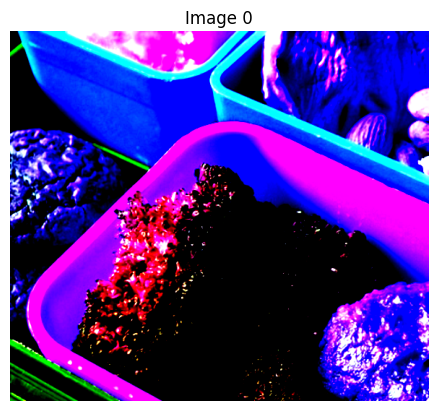

Annotations:
{'boxes': tensor([[0.5178, 0.6160, 0.9645, 0.7680],
        [0.3858, 0.1788, 0.7717, 0.3575],
        [0.5369, 0.6736, 0.7736, 0.6528],
        [0.7357, 0.3944, 0.5286, 0.7889],
        [0.4880, 0.0557, 0.2055, 0.1113]]), 'labels': tensor([51, 51, 56, 51, 55]), 'image_id': tensor([9]), 'area': tensor([219971.5781,  81928.4297, 149962.7969, 123827.1328,   6795.2471]), 'iscrowd': tensor([0, 0, 0, 0, 0]), 'orig_size': tensor([480, 640]), 'size': tensor([512, 580])}


In [46]:
import matplotlib.pyplot as plt

# Assuming you have defined the build method as shown in the provided code

# Set the image_set and args accordingly
image_set = "train"
coco_path = "./coco_dataset_test"

# Create the dataset using the build method
dataset = build(image_set, coco_path, strong_aug=True, fix_size=False)

# Iterate over the dataset to print images and annotations
for i in range(len(dataset)):
    # Get the image and target (annotations)
    image, target = dataset[i]
    
    # Convert image tensor to numpy array
    image_np = image.permute(1, 2, 0).numpy()

    # Plot the image
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f'Image {i}')
    plt.show()

    # Print annotations
    print("Annotations:")
    print(target)
    break


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## show image

loading annotations into memory...
Done (t=57.54s)
creating index...
index created!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


targets ({'boxes': tensor([[0.3821, 0.5036, 0.7642, 0.7427],
        [0.7896, 0.3359, 0.2908, 0.0835],
        [0.7398, 0.5038, 0.0405, 0.0771],
        [0.7242, 0.1596, 0.5380, 0.1169],
        [0.8560, 0.5069, 0.0472, 0.0776],
        [0.7564, 0.5110, 0.0196, 0.0628],
        [0.7429, 0.4305, 0.0140, 0.0587],
        [0.4975, 0.7618, 0.9915, 0.4539],
        [0.7595, 0.4275, 0.0146, 0.0616],
        [0.8906, 0.4265, 0.0189, 0.0674],
        [0.7739, 0.4225, 0.0237, 0.0728],
        [0.8037, 0.2522, 0.0270, 0.0706],
        [0.7234, 0.2567, 0.0880, 0.0723],
        [0.8746, 0.2372, 0.1240, 0.0862],
        [0.8320, 0.4286, 0.0200, 0.0594]]), 'labels': tensor([ 1, 84, 84, 84, 84, 84, 84, 65, 84, 84, 84, 84, 84, 84, 84]), 'image_id': tensor([5219]), 'area': tensor([111614.9766,   5978.0347,    593.1212,  12791.9990,    794.2114,
           235.0014,    172.3419, 104302.8828,    150.3171,    335.9476,
           493.6842,    564.4733,   2007.6901,   3184.9663,    344.9971]), 'iscrowd': t

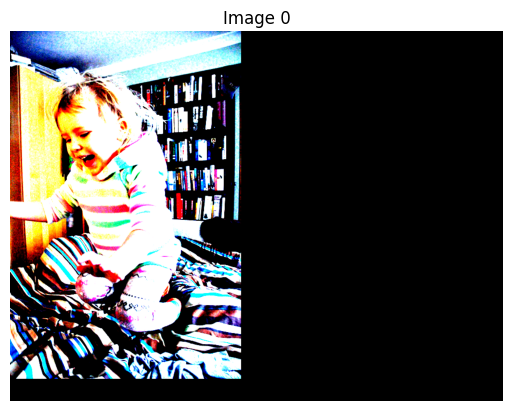

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


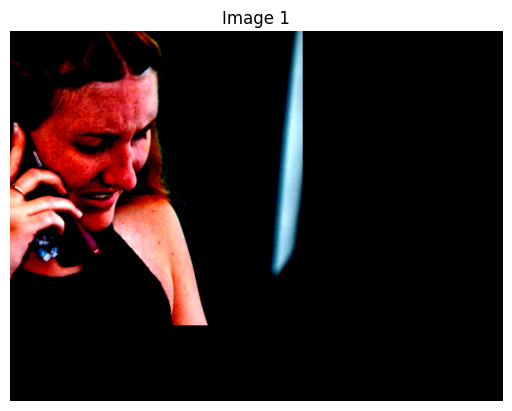

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


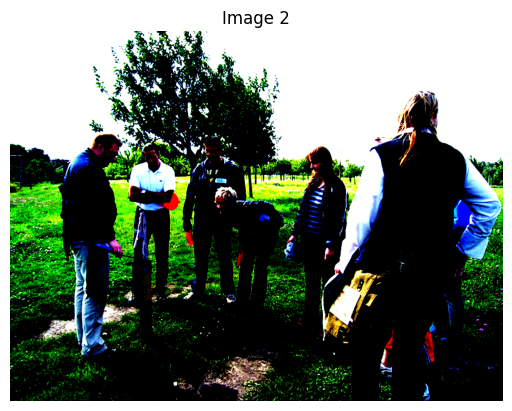

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


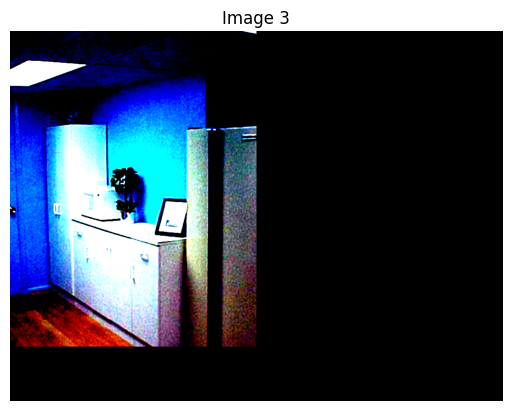

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


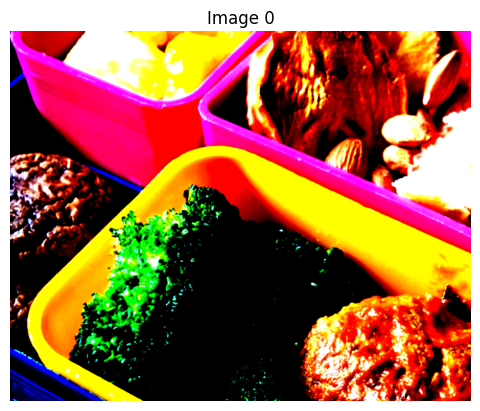

Annotations:
{'boxes': tensor([[0.5173, 0.6495, 0.9653, 0.7010],
        [0.3286, 0.2081, 0.6573, 0.4161],
        [0.4587, 0.7033, 0.6542, 0.5935],
        [0.7017, 0.4092, 0.5967, 0.8184],
        [0.4457, 0.0192, 0.1563, 0.0385],
        [0.2785, 0.0176, 0.1201, 0.0353],
        [0.4173, 0.0954, 0.1738, 0.1823],
        [0.4510, 0.0020, 0.1960, 0.0040]]), 'labels': tensor([51, 51, 56, 51, 55, 55, 55, 55]), 'image_id': tensor([9]), 'area': tensor([418253.1875, 169056.7031, 240007.4375, 301846.0312,   3718.3142,
          2618.0808,  19581.7070,    488.6127]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0]), 'orig_size': tensor([480, 640]), 'size': tensor([704, 878])}


In [47]:
import matplotlib.pyplot as plt

# Assuming you have defined the build method as shown in the provided code

# Set the image_set and args accordingly
image_set = "train"
coco_path = "./coco_dataset_test"

# Create the dataset using the build method
dataset = build(image_set, coco_path, strong_aug=True, fix_size=False)
dataloader_train = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=utils.collate_fn)

for batch in dataloader_train:
    images, targets = batch
    #targets =[ target.to(device) for target in targets]
    #images = list(img.to(device) for img in images)
    print("targets",targets)
     

    print(F"targets=", targets)
    print(F"images=", images)
        # Convert image tensor to numpy array
    # Iterate over the images in the NestedTensor
    images_list = images.tensors
    for i, image in enumerate(images_list):
        # Get the image
        
        image_np = image.permute(1, 2, 0).numpy()

        # Plot the image
        plt.imshow(image_np)
        plt.axis('off')
        plt.title(f'Image {i}')
        plt.show()
        
    #for i, image in enumerate(images):
        #print(f"Shape of image {i}: {image.shape}")
        
    #images_tensor = torch.stack(images)
    #print(images_tensor.shape)
    
     # Get color images (assuming images are in RGB format)
    #color_images = [F.to_pil_image(image.cpu()) for image in images]

    # Display color images
    #for i, color_image in enumerate(color_images):
        #plt.imshow(color_image)
        #plt.show()

    # Access tensors (boxes, labels, image_ids, ids) for further processing
    #for target in targets:
        #Access target data, e.g., boxes, labels, etc.
        #boxes = target[:, :4]
        #labels = target[:, 4]
        #image_ids = target[:, 5]
        #ids = target[:, 6]
        #print(boxes, labels, image_ids, ids)
    break

# Iterate over the dataset to print images and annotations
for i in range(len(dataset)):
    # Get the image and target (annotations)
    image, target = dataset[i]
    
    # Convert image tensor to numpy array
    image_np = image.permute(1, 2, 0).numpy()

    # Plot the image
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f'Image {i}')
    plt.show()

    # Print annotations
    print("Annotations:")
    print(target)
    break


## COCO evaluator

In [19]:

"""
COCO evaluator that works in distributed mode.

Mostly copy-paste from https://github.com/pytorch/vision/blob/edfd5a7/references/detection/coco_eval.py
The difference is that there is less copy-pasting from pycocotools
in the end of the file, as python3 can suppress prints with contextlib
"""

class CocoEvaluator(object):
    def __init__(self, coco_gt, iou_types, useCats=True):
        assert isinstance(iou_types, (list, tuple))
        coco_gt = copy.deepcopy(coco_gt)
        self.coco_gt = coco_gt

        self.iou_types = iou_types
        self.coco_eval = {}  # is a dictionary where each key is an IoU type and each value is a COCOeval object
        for iou_type in iou_types:
            self.coco_eval[iou_type] = COCOeval(coco_gt, iouType=iou_type)
            self.coco_eval[iou_type].useCats = useCats

        self.img_ids = []
        self.eval_imgs = {k: [] for k in iou_types}
        self.useCats = useCats

    def update(self, predictions):
        img_ids = list(np.unique(list(predictions.keys())))
        self.img_ids.extend(img_ids)

        for iou_type in self.iou_types:
            results = self.prepare(predictions, iou_type)

            # suppress pycocotools prints
            with open(os.devnull, 'w') as devnull:
                with contextlib.redirect_stdout(devnull):
                    coco_dt = COCO.loadRes(self.coco_gt, results) if results else COCO()
            coco_eval = self.coco_eval[iou_type]

            coco_eval.cocoDt = coco_dt
            coco_eval.params.imgIds = list(img_ids)
            coco_eval.params.useCats = self.useCats
            img_ids, eval_imgs = evaluate(coco_eval)

            self.eval_imgs[iou_type].append(eval_imgs)

    def synchronize_between_processes(self):
        for iou_type in self.iou_types:
            self.eval_imgs[iou_type] = np.concatenate(self.eval_imgs[iou_type], 2)
            create_common_coco_eval(self.coco_eval[iou_type], self.img_ids, self.eval_imgs[iou_type])

    def accumulate(self):
        for coco_eval in self.coco_eval.values():
            coco_eval.accumulate()

    def summarize(self):
        for iou_type, coco_eval in self.coco_eval.items():
            print("IoU metric: {}".format(iou_type))
            coco_eval.summarize()

    def prepare(self, predictions, iou_type):
        if iou_type == "bbox":
            return self.prepare_for_coco_detection(predictions)
        #elif iou_type == "segm":
            #return self.prepare_for_coco_segmentation(predictions)
        elif iou_type == "keypoints":
            return self.prepare_for_coco_keypoint(predictions)
        else:
            raise ValueError("Unknown iou type {}".format(iou_type))

    def prepare_for_coco_detection(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            if not isinstance(prediction["scores"], list):
                scores = prediction["scores"].tolist()
            else:
                scores = prediction["scores"]
            if not isinstance(prediction["labels"], list):
                labels = prediction["labels"].tolist()
            else:
                labels = prediction["labels"]

        
            try:
                coco_results.extend(
                    [
                        {
                            "image_id": original_id,
                            "category_id": labels[k],
                            "bbox": box,
                            "score": scores[k],
                        }
                        for k, box in enumerate(boxes)
                    ]
                )
            except:
                import ipdb; 
                ipdb.set_trace()
        return coco_results

    """def prepare_for_coco_segmentation(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            scores = prediction["scores"]
            labels = prediction["labels"]
            masks = prediction["masks"]

            masks = masks > 0.5

            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            rles = [
                mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0]
                for mask in masks
            ]
            for rle in rles:
                rle["counts"] = rle["counts"].decode("utf-8")

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "segmentation": rle,
                        "score": scores[k],
                    }
                    for k, rle in enumerate(rles)
                ]
            )
        return coco_results"""

    def prepare_for_coco_keypoint(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()
            keypoints = prediction["keypoints"]
            keypoints = keypoints.flatten(start_dim=1).tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        'keypoints': keypoint,
                        "score": scores[k],
                    }
                    for k, keypoint in enumerate(keypoints)
                ]
            )
        return coco_results


def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)


def merge(img_ids, eval_imgs):
    all_img_ids = all_gather(img_ids)
    all_eval_imgs = all_gather(eval_imgs)

    merged_img_ids = []
    for p in all_img_ids:
        merged_img_ids.extend(p)

    merged_eval_imgs = []
    for p in all_eval_imgs:
        merged_eval_imgs.append(p)

    merged_img_ids = np.array(merged_img_ids)
    merged_eval_imgs = np.concatenate(merged_eval_imgs, 2)

    # keep only unique (and in sorted order) images
    merged_img_ids, idx = np.unique(merged_img_ids, return_index=True)
    merged_eval_imgs = merged_eval_imgs[..., idx]

    return merged_img_ids, merged_eval_imgs


def create_common_coco_eval(coco_eval, img_ids, eval_imgs):
    img_ids, eval_imgs = merge(img_ids, eval_imgs)
    img_ids = list(img_ids)
    eval_imgs = list(eval_imgs.flatten())

    coco_eval.evalImgs = eval_imgs
    coco_eval.params.imgIds = img_ids
    coco_eval._paramsEval = copy.deepcopy(coco_eval.params)


#################################################################
# From pycocotools, just removed the prints and fixed
# a Python3 bug about unicode not defined
#################################################################


def evaluate(self):
    '''
    Run per image evaluation on given images and store results (a list of dict) in self.evalImgs
    :return: None
    '''
    # tic = time.time()
    # print('Running per image evaluation...')
    p = self.params #  retrieving the evaluation parameters stored in self.params
    # add backward compatibility if useSegm is specified in params
    if p.useSegm is not None:
        p.iouType = 'segm' if p.useSegm == 1 else 'bbox'
        print('useSegm (deprecated) is not None. Running {} evaluation'.format(p.iouType))
    # print('Evaluate annotation type *{}*'.format(p.iouType))
    p.imgIds = list(np.unique(p.imgIds))
    if p.useCats:
        p.catIds = list(np.unique(p.catIds))
    p.maxDets = sorted(p.maxDets)
    self.params = p

    self._prepare()
    # loop through images, area range, max detection number
    catIds = p.catIds if p.useCats else [-1]

    if p.iouType == 'segm' or p.iouType == 'bbox':
        computeIoU = self.computeIoU
    elif p.iouType == 'keypoints':
        computeIoU = self.computeOks
    self.ious = {
        (imgId, catId): computeIoU(imgId, catId)
        for imgId in p.imgIds
        for catId in catIds}

    evaluateImg = self.evaluateImg
    maxDet = p.maxDets[-1]
    evalImgs = [
        evaluateImg(imgId, catId, areaRng, maxDet)
        for catId in catIds
        for areaRng in p.areaRng
        for imgId in p.imgIds
    ]
    # this is NOT in the pycocotools code, but could be done outside
    evalImgs = np.asarray(evalImgs).reshape(len(catIds), len(p.areaRng), len(p.imgIds))
    self._paramsEval = copy.deepcopy(self.params)
    # toc = time.time()
    # print('DONE (t={:0.2f}s).'.format(toc-tic))
    return p.imgIds, evalImgs

#################################################################
# end of straight copy from pycocotools, just removing the prints
#################################################################

## Backbone Model

In [20]:
if not torch.cuda.is_available():
    raise SystemError('GPU device not found')
device = torch.device("cuda:0")

### backbone model

In [21]:

from resnetbackbone import build_backbone
from util.misc import NestedTensor, nested_tensor_from_tensor_list

In [9]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define your arguments
class Args:
    def __init__(self):
        self.backbone = "resnet50"  # or any other supported backbone
        self.lr_backbone = 0.1  # example learning rate for backbone, adjust as needed
        self.masks = False  # whether to include masks in the output
        self.num_feature_levels = 1  # number of feature levels, adjust as needed
        self.dilation = False  # whether to use dilation in backbone
        self.hidden_dim = 256  # hidden dimension for transformer
        self.position_embedding = "sine"  # type of position embedding to use

args = Args()

# Build the backbone model
model =build_backbone(args).to(device)

# Assuming you have input data 'input_data', pass it through the model
# input_data should be a NestedTensor, which is a tensor with an associated mask
# Example usage assuming input_data is properly defined
#output = model(nested_images)

with torch.no_grad():
    all_extracted_features = []
    all_outputs = []

    for batch in dataloader_train:
        images, targets = batch
        targets = [target.to(device) for target in targets]
        images = [img.to(device) for img in images]
        #print("shape of images",images[0].shape)
        #for img in images:
            #print(img.shape)
            #break
        mask = [torch.ones_like(img) for img in images]
        nested_images = nested_tensor_from_tensor_list(images).to(device)
        output,extracted_features = model(nested_images)
        #print("shape of extracted_features")
        #for img in extracted_features:
            #print(img.shape)
            #break
        
        #print("shape of output")
        #for img in output:
            #for i in img.tensors:
                #print(i.shape)
                #break
            
        #all_extracted_features.append(extracted_features.detach())
         # Append the output and extracted features to the lists
        all_outputs.append(output)
        all_extracted_features.append(extracted_features)
            # Clear the memory
        del images, targets, output, extracted_features
        torch.cuda.empty_cache()

    # Save the lists of outputs and extracted features
    torch.save(all_outputs, os.path.join(os.getcwd(), 'all_outputs.pt'))
    torch.save(all_extracted_features, os.path.join(os.getcwd(), 'all_extracted_features.pt'))
        
    #print("shape of image",images)
    # Concatenate features from all batches
    #all_extracted_features = torch.cat(all_extracted_features, dim=0)

#print("Shape of all extracted features:", all_extracted_features.shape)

C:\Users\Rahman\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Rahman\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the lists of outputs and extracted features in cpu memory
all_outputs = torch.load(os.path.join(os.getcwd(), 'all_outputs.pt'), map_location='cpu')
all_extracted_features = torch.load(os.path.join(os.getcwd(), 'all_extracted_features.pt'), map_location='cpu')

# Now you can use all_outputs and all_extracted_features in your code

In [ ]:
for i, batch in enumerate(all_extracted_features):
    for j, tensor in enumerate(batch):
        print(f"Shape of tensor {j} in batch {i}: {tensor.shape}")
        

In [ ]:
print("shape of all_outputs",all_extracted_features)

In [ ]:
print("shape of all_outputs",all_outputs)

## Reshape All Extracted Feature

In [22]:
reshaped_features = []

for batch in all_extracted_features:
    reshaped_batch = [tensor.permute(2, 3, 0, 1).contiguous().view(-1, *tensor.shape[:2]) for tensor in batch]
    reshaped_features.append(reshaped_batch)

In [ ]:
for i, batch in enumerate(reshaped_features):
    for j, tensor in enumerate(batch):
        print(f"Shape of tensor {j} in batch {i}: {tensor.shape}")

## DETR model ( From DAB detr model)

In [22]:

import ipykernel

import import_ipynb
from typing import List, Tuple, Dict
import copy

import torch.nn.functional as F
from torch import nn, Tensor

import warnings
from typing import Optional, Tuple
from torch.nn.modules.linear import Linear
from torch.nn.init import xavier_uniform_
from torch.nn.init import constant_
from torch.nn.init import xavier_normal_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

import math

from torch._C import _infer_size, _add_docstr
from torch.nn import _reduction as _Reduction
from torch.nn.modules import utils
from torch.nn.modules.utils import _single, _pair, _triple, _list_with_default
from torch.nn import grad
from torch import _VF
from torch._jit_internal import boolean_dispatch, List, Optional, Tuple, ignore, _overload
try:
    from torch.overrides import has_torch_function, handle_torch_function
except:
    from torch.overrides import has_torch_function, handle_torch_function
Tensor = torch.Tensor

from torch.nn.functional import linear,pad,relu,softmax,dropout   

In [23]:
class SimpleDetr(nn.Module):
    
## positional embedding
    @staticmethod
    def position_embedding_sine(tensor_list, num_pos_feats=64, temperature=10000, normalize=False, scale=None):
        x = tensor_list.tensors
        print(f"x:{x}")
    
        mask = tensor_list.mask
        assert mask is not None
        not_mask = ~mask
        y_embed = not_mask.cumsum(1, dtype=torch.float32)
        x_embed = not_mask.cumsum(2, dtype=torch.float32)
        if normalize:
            eps = 1e-6
            y_embed = y_embed / (y_embed[:, -1:, :] + eps) * (2 * math.pi)
            x_embed = x_embed / (x_embed[:, :, -1:] + eps) * (2 * math.pi)

        dim_t = torch.arange(num_pos_feats, dtype=torch.float32, device=x.device)
        dim_t = temperature ** (2 * (dim_t // 2) / num_pos_feats)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos
    
    @staticmethod
    def position_embedding_learned(tensor_list, num_pos_feats=256):
        x = tensor_list.tensors
        h, w = x.shape[-2:]
        i = torch.arange(w, device=x.device)
        j = torch.arange(h, device=x.device)
        
        i = i.clamp(max=49)
        j = j.clamp(max=49)
        
        x_emb = nn.Embedding(50, num_pos_feats)(i)
        y_emb = nn.Embedding(50, num_pos_feats)(j)
        pos = torch.cat([
            x_emb.unsqueeze(0).repeat(h, 1, 1),
            y_emb.unsqueeze(1).repeat(1, w, 1),
        ], dim=-1).permute(2, 0, 1).unsqueeze(0).repeat(x.shape[0], 1, 1, 1)
        return pos


    @staticmethod
    def build_position_encoding(position_embedding, hidden_dim=256):
        N_steps = hidden_dim // 2
        if position_embedding in ('v2', 'sine'):
            position_embedding = SimpleDetr.position_embedding_sine
        elif position_embedding in ('v3', 'learned'):
            position_embedding = SimpleDetr.position_embedding_learned
        else:
            raise ValueError(f"not supported {position_embedding}")

        return position_embedding
    

def gen_sineembed_for_position(pos_tensor, d_model=256):
    # n_query, bs, _ = pos_tensor.size()
    # sineembed_tensor = torch.zeros(n_query, bs, 256)
    scale = 2 * math.pi
    dim_t = torch.arange(d_model // 2, dtype=torch.float32, device=pos_tensor.device)
    dim_t = 10000 ** (2 * (dim_t // 2) / (d_model // 2))
    
    x_embed = pos_tensor[:, :, 0] * scale
    y_embed = pos_tensor[:, :, 1] * scale
    
    pos_x = x_embed[:, :, None] / dim_t
    pos_y = y_embed[:, :, None] / dim_t
    pos_x = torch.stack((pos_x[:, :, 0::2].sin(), pos_x[:, :, 1::2].cos()), dim=3).flatten(2)
    pos_y = torch.stack((pos_y[:, :, 0::2].sin(), pos_y[:, :, 1::2].cos()), dim=3).flatten(2)
    if pos_tensor.size(-1) == 2:
        pos = torch.cat((pos_y, pos_x), dim=2)
    elif pos_tensor.size(-1) == 4:
        w_embed = pos_tensor[:, :, 2] * scale
        pos_w = w_embed[:, :, None] / dim_t
        pos_w = torch.stack((pos_w[:, :, 0::2].sin(), pos_w[:, :, 1::2].cos()), dim=3).flatten(2)

        h_embed = pos_tensor[:, :, 3] * scale
        pos_h = h_embed[:, :, None] / dim_t
        pos_h = torch.stack((pos_h[:, :, 0::2].sin(), pos_h[:, :, 1::2].cos()), dim=3).flatten(2)

        pos = torch.cat((pos_y, pos_x, pos_w, pos_h), dim=2)
    else:
        raise ValueError("Unknown pos_tensor shape(-1):{}".format(pos_tensor.size(-1)))
    return pos


## Feed forward Block

In [24]:
class FFN(nn.Module): # Multi Layer Perceptron (MLP) for the feedforward network

    def __init__(self, d_model: int, hidden_dim: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, hidden_dim) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(hidden_dim, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, hidden_dim) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

In [25]:
class MLP(nn.Module):
    """ Very simple multi-layer perceptron (also called FFN)"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x

## MultiHeadAttentionBlock

In [26]:
class MultiheadAttention(Module):

    bias_k: Optional[torch.Tensor]
    bias_v: Optional[torch.Tensor]

    def __init__(self, embed_dim, num_heads, dropout=0., bias=True, add_bias_kv=False, add_zero_attn=False, kdim=None, vdim=None):
        super(MultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        vdim = vdim if vdim is not None else embed_dim
        self.out_proj = Linear(vdim , vdim)

        self.in_proj_bias = None
        self.in_proj_weight = None
        self.bias_k = self.bias_v = None
        self.q_proj_weight = None
        self.k_proj_weight = None
        self.v_proj_weight = None

        self.add_zero_attn = add_zero_attn

        self._reset_parameters()

    def _reset_parameters(self):
        constant_(self.out_proj.bias, 0.)

    def __setstate__(self, state):
        # Support loading old MultiheadAttention checkpoints generated by v1.1.0
        if '_qkv_same_embed_dim' not in state:
            state['_qkv_same_embed_dim'] = True

        super(MultiheadAttention, self).__setstate__(state)

    def forward(self, query, key, value, key_padding_mask=None,
                need_weights=True, attn_mask=None):
        # type: (Tensor, Tensor, Tensor, Optional[Tensor], bool, Optional[Tensor]) -> Tuple[Tensor, Optional[Tensor]]


        if not self._qkv_same_embed_dim:
            return multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask, use_separate_proj_weight=True,
                q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
                v_proj_weight=self.v_proj_weight, out_dim=self.vdim)
        else:
            return multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask, out_dim=self.vdim)


def multi_head_attention_forward(query: Tensor,
                                 key: Tensor,
                                 value: Tensor,
                                 embed_dim_to_check: int,
                                 num_heads: int,
                                 in_proj_weight: Tensor,
                                 in_proj_bias: Tensor,
                                 bias_k: Optional[Tensor],
                                 bias_v: Optional[Tensor],
                                 add_zero_attn: bool,
                                 dropout_p: float,
                                 out_proj_weight: Tensor,
                                 out_proj_bias: Tensor,
                                 training: bool = True,
                                 key_padding_mask: Optional[Tensor] = None,
                                 need_weights: bool = True,
                                 attn_mask: Optional[Tensor] = None,
                                 use_separate_proj_weight: bool = False,
                                 q_proj_weight: Optional[Tensor] = None,
                                 k_proj_weight: Optional[Tensor] = None,
                                 v_proj_weight: Optional[Tensor] = None,
                                 static_k: Optional[Tensor] = None,
                                 static_v: Optional[Tensor] = None,
                                 out_dim: Optional[Tensor] = None
                                 ) -> Tuple[Tensor, Optional[Tensor]]:
    
    
    if not torch.jit.is_scripting():
        tens_ops = (query, key, value, in_proj_weight, in_proj_bias, bias_k, bias_v,
                    out_proj_weight, out_proj_bias)
        if any([type(t) is not Tensor for t in tens_ops]) and has_torch_function(tens_ops):
            return handle_torch_function(
                multi_head_attention_forward, tens_ops, query, key, value,
                embed_dim_to_check, num_heads, in_proj_weight, in_proj_bias,
                bias_k, bias_v, add_zero_attn, dropout_p, out_proj_weight,
                out_proj_bias, training=training, key_padding_mask=key_padding_mask,
                need_weights=need_weights, attn_mask=attn_mask,
                use_separate_proj_weight=use_separate_proj_weight,
                q_proj_weight=q_proj_weight, k_proj_weight=k_proj_weight,
                v_proj_weight=v_proj_weight, static_k=static_k, static_v=static_v)
    tgt_len, bsz, embed_dim = query.size()
    assert embed_dim == embed_dim_to_check
    # allow MHA to have different sizes for the feature dimension
    assert key.size(0) == value.size(0) and key.size(1) == value.size(1)

    head_dim = embed_dim // num_heads
    v_head_dim = out_dim // num_heads
    assert head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
    scaling = float(head_dim) ** -0.5

    q = query * scaling
    k = key
    v = value

    if attn_mask is not None:
        assert attn_mask.dtype == torch.float32 or attn_mask.dtype == torch.float64 or \
            attn_mask.dtype == torch.float16 or attn_mask.dtype == torch.uint8 or attn_mask.dtype == torch.bool, \
            'Only float, byte, and bool types are supported for attn_mask, not {}'.format(attn_mask.dtype)
        if attn_mask.dtype == torch.uint8:
            warnings.warn("Byte tensor for attn_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
            attn_mask = attn_mask.to(torch.bool)

        if attn_mask.dim() == 2:
            attn_mask = attn_mask.unsqueeze(0)
            if list(attn_mask.size()) != [1, query.size(0), key.size(0)]:
                raise RuntimeError('The size of the 2D attn_mask is not correct.')
        elif attn_mask.dim() == 3:
            if list(attn_mask.size()) != [bsz * num_heads, query.size(0), key.size(0)]: # bsz is batch size
                raise RuntimeError('The size of the 3D attn_mask is not correct.')
        else:
            raise RuntimeError("attn_mask's dimension {} is not supported".format(attn_mask.dim()))
        # attn_mask's dim is 3 now.

    # convert ByteTensor key_padding_mask to bool
    if key_padding_mask is not None and key_padding_mask.dtype == torch.uint8:
        warnings.warn("Byte tensor for key_padding_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
        key_padding_mask = key_padding_mask.to(torch.bool)

    if bias_k is not None and bias_v is not None:
        if static_k is None and static_v is None:
            k = torch.cat([k, bias_k.repeat(1, bsz, 1)])
            v = torch.cat([v, bias_v.repeat(1, bsz, 1)])
            if attn_mask is not None:
                attn_mask = pad(attn_mask, (0, 1))
            if key_padding_mask is not None:
                key_padding_mask = pad(key_padding_mask, (0, 1))
        else:
            assert static_k is None, "bias cannot be added to static key."
            assert static_v is None, "bias cannot be added to static value."
    else:
        assert bias_k is None
        assert bias_v is None
        
 # reshaping the input to be compatible with the linear projection
    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1) 
    if k is not None:
        k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)  # bsz is batch size
    if v is not None:
        v = v.contiguous().view(-1, bsz * num_heads, v_head_dim).transpose(0, 1)

    if static_k is not None:
        assert static_k.size(0) == bsz * num_heads
        assert static_k.size(2) == head_dim
        k = static_k

    if static_v is not None:
        assert static_v.size(0) == bsz * num_heads # bsz is batch size
        assert static_v.size(2) == v_head_dim
        v = static_v

    src_len = k.size(1)

    if key_padding_mask is not None:
        assert key_padding_mask.size(0) == bsz  # bsz is batch size
        assert key_padding_mask.size(1) == src_len

    if add_zero_attn:
        src_len += 1
        k = torch.cat([k, torch.zeros((k.size(0), 1) + k.size()[2:], dtype=k.dtype, device=k.device)], dim=1)
        v = torch.cat([v, torch.zeros((v.size(0), 1) + v.size()[2:], dtype=v.dtype, device=v.device)], dim=1)
        if attn_mask is not None:
            attn_mask = pad(attn_mask, (0, 1))
        if key_padding_mask is not None:
            key_padding_mask = pad(key_padding_mask, (0, 1))

    attn_output_weights = torch.bmm(q, k.transpose(1, 2)) # batch matrix multiplication (torch.bmm) q and k
    assert list(attn_output_weights.size()) == [bsz * num_heads, tgt_len, src_len]

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_output_weights.masked_fill_(attn_mask, float('-inf'))
        else:
            attn_output_weights += attn_mask


    if key_padding_mask is not None:
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        attn_output_weights = attn_output_weights.masked_fill(
            key_padding_mask.unsqueeze(1).unsqueeze(2),
            float('-inf'),
        )
        attn_output_weights = attn_output_weights.view(bsz * num_heads, tgt_len, src_len)

    # attn_output_weights = softmax(
    #     attn_output_weights, dim=-1)
    attn_output_weights = softmax(
            attn_output_weights - attn_output_weights.max(dim=-1, keepdim=True)[0], dim=-1)
    attn_output_weights = dropout(attn_output_weights, p=dropout_p, training=training)

    attn_output = torch.bmm(attn_output_weights, v) # batch matrix multiplication (torch.bmm) with v
    assert list(attn_output.size()) == [bsz * num_heads, tgt_len, v_head_dim]
    attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, out_dim)
    attn_output = linear(attn_output, out_proj_weight, out_proj_bias)

    if need_weights:
        # average attention weights over heads
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        return attn_output, attn_output_weights.sum(dim=1) / num_heads
    else:
        return attn_output, None

## Necessary functions for the transformer

In [27]:
def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

def inverse_sigmoid(x, eps=1e-3):
    x = x.clamp(min=0, max=1)
    x1 = x.clamp(min=eps)
    x2 = (1 - x).clamp(min=eps)
    return torch.log(x1/x2)

def _get_activation_fn(activation):
    """Return an activation function given a string"""
    if activation == "relu":
        return F.relu
    if activation == "gelu":
        return F.gelu
    if activation == "glu":
        return F.glu
    if activation == "prelu":
        return nn.PReLU()
    if activation == "selu":
        return F.selu
    raise RuntimeError(F"activation should be relu/gelu, not {activation}.")


## Encoder Block

In [28]:
class TransformerEncoder(nn.Module):

    def __init__(self, encoder_layer, num_layers, norm=None, d_model=256):
        super().__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.query_scale = MLP(d_model, d_model, d_model, 2)
        self.norm = norm

    def forward(self, src,
                mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None):
        output = src

        for layer_id, layer in enumerate(self.layers):
            # rescale the content and pos sim
            pos_scales = self.query_scale(output)
            output = layer(output, src_mask=mask,
                           src_key_padding_mask=src_key_padding_mask, pos=pos*pos_scales)

        if self.norm is not None:
            output = self.norm(output)

        return output
    


## Encoder layer

In [29]:
class TransformerEncoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)
        self.normalize_before = normalize_before

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    def forward(self,
                     src,
                     src_mask: Optional[Tensor] = None,
                     src_key_padding_mask: Optional[Tensor] = None,
                     pos: Optional[Tensor] = None):
        q = k = self.with_pos_embed(src, pos)
        src2 = self.self_attn(q, k, value=src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

Output of tensor 0 in batch 0: tensor([[[-0.3885,  0.9498, -0.8826,  ...,  0.5136, -0.9445,  0.5277],
         [-0.4384,  0.9879, -0.8832,  ...,  1.1553, -1.1892,  0.7774]],

        [[-0.4209,  0.8454, -0.8895,  ...,  0.6238, -1.2085,  0.8278],
         [-0.3853,  0.9796, -0.4578,  ...,  0.6376, -1.3442,  0.7880]],

        [[-0.2196,  0.9084, -0.6717,  ...,  0.8378, -1.2772,  0.8553],
         [-0.1266,  0.8652, -0.8137,  ...,  0.8386, -1.3387,  1.0660]],

        ...,

        [[-1.1215,  1.3399, -2.3500,  ...,  0.5502, -0.9465,  0.9118],
         [-0.9953,  1.1721, -2.6869,  ...,  0.4339, -1.2141,  1.0077]],

        [[-1.0628,  1.2274, -2.4335,  ...,  0.5800, -1.2173,  0.9819],
         [-1.3964,  1.2702, -2.5583,  ...,  0.5111, -0.7815,  1.0940]],

        [[-1.1676,  1.3344, -2.6887,  ...,  0.4503, -0.9572,  1.1817],
         [-1.4535,  1.2986, -2.7618,  ...,  0.5679, -1.0360,  1.1714]]],
       grad_fn=<NativeLayerNormBackward0>)
Shape of output: torch.Size([169, 2, 256])
Outpu

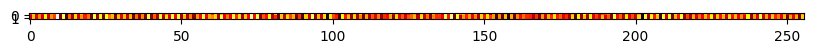

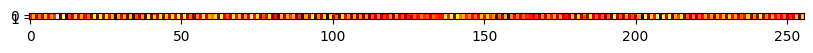

In [42]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
encoder_layer = TransformerEncoderLayer(d_model=256, nhead=8, dim_feedforward=2048, dropout=0.1, activation="relu", normalize_before=False)

# Assume reshaped_features is your list of reshaped image features
for i, batch in enumerate(reshaped_features):
    for j, src in enumerate(batch):
        
        # Pass the tensor through the encoder layer
        output = encoder_layer(src)

        # Print the output
        print(f"Output of tensor {j} in batch {i}: {output}")
                # Print the shape of the output
        print(f"Shape of output: {output.shape}")       
        

for i in range(output.shape[1]):
    plt.figure(figsize=(10,10))
    plt.imshow(output.detach().numpy()[i], cmap='hot', interpolation='nearest')
    plt.show()

## Decoder Block

In [30]:
class TransformerDecoder(nn.Module):

    def __init__(self, decoder_layer, num_layers, norm=None, return_intermediate=False, 
                    d_model=256, query_dim=2, keep_query_pos=False, query_scale_type='cond_elewise',
                    modulate_hw_attn=False,
                    bbox_embed_diff_each_layer=False,
                    ):
        super().__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
        self.return_intermediate = return_intermediate
        assert return_intermediate
        self.query_dim = query_dim

        assert query_scale_type in ['cond_elewise', 'cond_scalar', 'fix_elewise']
        self.query_scale_type = query_scale_type
        if query_scale_type == 'cond_elewise':
            self.query_scale = MLP(d_model, d_model, d_model, 2)
        elif query_scale_type == 'cond_scalar':
            self.query_scale = MLP(d_model, d_model, 1, 2)
        elif query_scale_type == 'fix_elewise':
            self.query_scale = nn.Embedding(num_layers, d_model)
        else:
            raise NotImplementedError("Unknown query_scale_type: {}".format(query_scale_type))
        
        self.ref_point_head = MLP(query_dim // 2 * d_model, d_model, d_model, 2)
        
        self.bbox_embed = None
        self.d_model = d_model
        self.modulate_hw_attn = modulate_hw_attn
        self.bbox_embed_diff_each_layer = bbox_embed_diff_each_layer


        if modulate_hw_attn:
            self.ref_anchor_head = MLP(d_model, d_model, 2, 2)

        
        if not keep_query_pos:
            for layer_id in range(num_layers - 1):
                self.layers[layer_id + 1].ca_qpos_proj = None

    def forward(self, tgt, memory,
                tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None,
                refpoints_unsigmoid: Optional[Tensor] = None, # num_queries, bs, 2
                ):
        output = tgt

        intermediate = []
        reference_points = refpoints_unsigmoid.sigmoid()
        ref_points = [reference_points]

        # import ipdb; ipdb.set_trace()        

        for layer_id, layer in enumerate(self.layers):
            obj_center = reference_points[..., :self.query_dim]     # [num_queries, batch_size, 2]
            # get sine embedding for the query vector
            query_sine_embed = gen_sineembed_for_position(obj_center, self.d_model)  
            query_pos = self.ref_point_head(query_sine_embed) 

            # For the first decoder layer, we do not apply transformation over p_s
            if self.query_scale_type != 'fix_elewise':
                if layer_id == 0:
                    pos_transformation = 1
                else:
                    pos_transformation = self.query_scale(output)
            else:
                pos_transformation = self.query_scale.weight[layer_id]

            # apply transformation
            query_sine_embed = query_sine_embed[...,:self.d_model] * pos_transformation

            # modulated HW attentions
            if self.modulate_hw_attn:
                refHW_cond = self.ref_anchor_head(output).sigmoid() # nq, bs, 2
                query_sine_embed[..., self.d_model // 2:] *= (refHW_cond[..., 0] / obj_center[..., 2]).unsqueeze(-1)
                query_sine_embed[..., :self.d_model // 2] *= (refHW_cond[..., 1] / obj_center[..., 3]).unsqueeze(-1)


            output = layer(output, memory, tgt_mask=tgt_mask,
                           memory_mask=memory_mask,
                           tgt_key_padding_mask=tgt_key_padding_mask,
                           memory_key_padding_mask=memory_key_padding_mask,
                           pos=pos, query_pos=query_pos, query_sine_embed=query_sine_embed,
                           is_first=(layer_id == 0))

            # iter update
            if self.bbox_embed is not None:
                if self.bbox_embed_diff_each_layer:
                    tmp = self.bbox_embed[layer_id](output)
                else:
                    tmp = self.bbox_embed(output)
                # import ipdb; ipdb.set_trace()
                tmp[..., :self.query_dim] += inverse_sigmoid(reference_points)
                new_reference_points = tmp[..., :self.query_dim].sigmoid()
                if layer_id != self.num_layers - 1:
                    ref_points.append(new_reference_points)
                reference_points = new_reference_points.detach()

            if self.return_intermediate:
                intermediate.append(self.norm(output))

        if self.norm is not None:
            output = self.norm(output)
            if self.return_intermediate:
                intermediate.pop()
                intermediate.append(output)

        if self.return_intermediate:
            if self.bbox_embed is not None:
                return [
                    torch.stack(intermediate).transpose(1, 2),
                    torch.stack(ref_points).transpose(1, 2),
                ]
            else:
                return [
                    torch.stack(intermediate).transpose(1, 2), 
                    reference_points.unsqueeze(0).transpose(1, 2)
                ]

        return output.unsqueeze(0)


## Decoder layer

In [31]:
class TransformerDecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False, keep_query_pos=False,
                 rm_self_attn_decoder=False):
        super().__init__()
        # Decoder Self-Attention
        if not rm_self_attn_decoder:
            self.sa_qcontent_proj = nn.Linear(d_model, d_model)
            self.sa_qpos_proj = nn.Linear(d_model, d_model)
            self.sa_kcontent_proj = nn.Linear(d_model, d_model)
            self.sa_kpos_proj = nn.Linear(d_model, d_model)
            self.sa_v_proj = nn.Linear(d_model, d_model)
            self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout, vdim=d_model)

            self.norm1 = nn.LayerNorm(d_model)
            self.dropout1 = nn.Dropout(dropout)

        # Decoder Cross-Attention
        self.ca_qcontent_proj = nn.Linear(d_model, d_model) # linear transformation to produce query content using y=Ax+b A= weight matrix, b = bias
        self.ca_qpos_proj = nn.Linear(d_model, d_model)
        self.ca_kcontent_proj = nn.Linear(d_model, d_model)
        self.ca_kpos_proj = nn.Linear(d_model, d_model)
        self.ca_v_proj = nn.Linear(d_model, d_model)
        self.ca_qpos_sine_proj = nn.Linear(d_model, d_model)
        self.cross_attn = MultiheadAttention(d_model*2, nhead, dropout=dropout, vdim=d_model)

        self.nhead = nhead
        self.rm_self_attn_decoder = rm_self_attn_decoder

        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)
        self.normalize_before = normalize_before
        self.keep_query_pos = keep_query_pos

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    def forward(self, tgt, memory,
                     tgt_mask: Optional[Tensor] = None,
                     memory_mask: Optional[Tensor] = None,
                     tgt_key_padding_mask: Optional[Tensor] = None,
                     memory_key_padding_mask: Optional[Tensor] = None,
                     pos: Optional[Tensor] = None,
                     query_pos: Optional[Tensor] = None,
                     query_sine_embed = None,
                     is_first = False):
                     
        # ========== Begin of Self-Attention =============
        if not self.rm_self_attn_decoder:
            # Apply projections here
            # shape: num_queries x batch_size x 256
            q_content = self.sa_qcontent_proj(tgt)      # target is the input of the first decoder layer. zero by default.
            q_pos = self.sa_qpos_proj(query_pos)
            k_content = self.sa_kcontent_proj(tgt)
            k_pos = self.sa_kpos_proj(query_pos)
            v = self.sa_v_proj(tgt)

            num_queries, bs, n_model = q_content.shape
            hw, _, _ = k_content.shape

            q = q_content + q_pos
            k = k_content + k_pos

            tgt2 = self.self_attn(q, k, value=v, attn_mask=tgt_mask,
                                key_padding_mask=tgt_key_padding_mask)[0]
            # ========== End of Self-Attention =============

            tgt = tgt + self.dropout1(tgt2)
            tgt = self.norm1(tgt)

        # ========== Begin of Cross-Attention =============
        # Apply projections here
        # shape: num_queries x batch_size x 256
        q_content = self.ca_qcontent_proj(tgt)
        k_content = self.ca_kcontent_proj(memory)
        v = self.ca_v_proj(memory)

        num_queries, bs, n_model = q_content.shape
        hw, _, _ = k_content.shape

        k_pos = self.ca_kpos_proj(pos)

        # For the first decoder layer, we concatenate the positional embedding predicted from 
        # the object query (the positional embedding) into the original query (key) in DETR.
        if is_first or self.keep_query_pos:
            q_pos = self.ca_qpos_proj(query_pos)
            q = q_content + q_pos
            k = k_content + k_pos
        else:
            q = q_content
            k = k_content

        q = q.view(num_queries, bs, self.nhead, n_model//self.nhead)
        query_sine_embed = self.ca_qpos_sine_proj(query_sine_embed)
        query_sine_embed = query_sine_embed.view(num_queries, bs, self.nhead, n_model//self.nhead)
        q = torch.cat([q, query_sine_embed], dim=3).view(num_queries, bs, n_model * 2)
        k = k.view(hw, bs, self.nhead, n_model//self.nhead)
        k_pos = k_pos.view(hw, bs, self.nhead, n_model//self.nhead)
        k = torch.cat([k, k_pos], dim=3).view(hw, bs, n_model * 2)

        tgt2 = self.cross_attn(query=q,
                                   key=k,
                                   value=v, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]               
        # ========== End of Cross-Attention =============

        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt   # tgt is the output of the first decoder layer. zero by default.

## ProjectionLayer needs to be edited to included

In [32]:
#class ProjectionLayer(nn.Module):

    #def __init__(self, d_model, vocab_size) -> None:
        #super().__init__()
        #self.proj = nn.Linear(d_model, vocab_size)

    #def forward(self, x) -> None:
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        #return self.proj(x)
    
class ProjectionLayer(nn.Module):

    def __init__(self, d_model, num_classes, box_dim) -> None: # d_model = 256, num_classes = 91, box_dim = 4
        super().__init__()
        self.class_proj = nn.Linear(d_model, num_classes)
        self.box_proj = nn.Linear(d_model, box_dim)

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, num_classes)
        class_logits = self.class_proj(x)
        # (batch, seq_len, d_model) --> (batch, seq_len, box_dim)
        box_regression = self.box_proj(x)
        return class_logits, box_regression

## Transformer Block

In [33]:
class Transformer(nn.Module):

    def __init__(self, d_model=256, nhead=8, num_queries=300, num_encoder_layers=6,
                 num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False,
                 return_intermediate_dec=False, query_dim=4,
                 keep_query_pos=False, query_scale_type='cond_elewise',
                 num_patterns=0,
                 modulate_hw_attn=True,
                 bbox_embed_diff_each_layer=False,
                 ):

        super().__init__()

        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward,
                                                dropout, activation, normalize_before)
        encoder_norm = nn.LayerNorm(d_model) if normalize_before else None
        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)

        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward,
                                                dropout, activation, normalize_before, keep_query_pos=keep_query_pos)
        decoder_norm = nn.LayerNorm(d_model)
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm,
                                          return_intermediate=return_intermediate_dec,
                                          d_model=d_model, query_dim=query_dim, keep_query_pos=keep_query_pos, query_scale_type=query_scale_type,
                                          modulate_hw_attn=modulate_hw_attn,
                                          bbox_embed_diff_each_layer=bbox_embed_diff_each_layer)

        self._reset_parameters()
        assert query_scale_type in ['cond_elewise', 'cond_scalar', 'fix_elewise']

        self.d_model = d_model
        self.nhead = nhead
        self.dec_layers = num_decoder_layers
        self.num_queries = num_queries
        self.num_patterns = num_patterns
        if not isinstance(num_patterns, int):
            Warning("num_patterns should be int but {}".format(type(num_patterns)))
            self.num_patterns = 0
        if self.num_patterns > 0:
            self.patterns = nn.Embedding(self.num_patterns, d_model)

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, mask, refpoint_embed, pos_embed):
        # flatten NxCxHxW to HWxNxC
        bs, c, h, w = src.shape
        src = src.flatten(2).permute(2, 0, 1)
        pos_embed = pos_embed.flatten(2).permute(2, 0, 1)
        refpoint_embed = refpoint_embed.unsqueeze(1).repeat(1, bs, 1)
        mask = mask.flatten(1)        
        memory = self.encoder(src, src_key_padding_mask=mask, pos=pos_embed)

        # query_embed = gen_sineembed_for_position(refpoint_embed)
        num_queries = refpoint_embed.shape[0]
        if self.num_patterns == 0:
            tgt = torch.zeros(num_queries, bs, self.d_model, device=refpoint_embed.device)
        else:
            tgt = self.patterns.weight[:, None, None, :].repeat(1, self.num_queries, bs, 1).flatten(0, 1) # n_q*n_pat, bs, d_model
            refpoint_embed = refpoint_embed.repeat(self.num_patterns, 1, 1) # n_q*n_pat, bs, d_model
            # import ipdb; ipdb.set_trace()
        hs, references = self.decoder(tgt, memory, memory_key_padding_mask=mask,
                          pos=pos_embed, refpoints_unsigmoid=refpoint_embed)
        return hs, references    # Transformer class, the return value will be a tuple containing hs and references

## Transformer

In [ ]:
def build_transformer(hidden_dim, dropout, nheads, num_queries, dim_feedforward, enc_layers, dec_layers,  num_patterns, pre_norm = False,
                      transformer_activation = 'prelu',
                      ):
    return Transformer(
        d_model=hidden_dim,
        dropout=dropout,
        nhead=nheads,
        num_queries=num_queries,
        dim_feedforward=dim_feedforward,
        num_encoder_layers=enc_layers,
        num_decoder_layers=dec_layers,
        normalize_before=pre_norm,
        return_intermediate_dec=True,
        query_dim=4,
        activation=transformer_activation,
        num_patterns=num_patterns,
    )

## X_DETR Model

In [35]:
def sigmoid_focal_loss(inputs, targets, num_boxes, alpha: float = 0.25, gamma: float = 2):
    prob = inputs.sigmoid()
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = prob * targets + (1 - prob) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    target_loss = loss.mean(1).sum() / num_boxes

    return target_loss
class DABDETR (nn.Module):
    def _init_(self, resnetbackbone, transformer, num_classes, num_queries, num_dec_layers, iter_update, query_dim, aux_loss=False, 
               bbox_embed_diff_each_layer=False, random_refpoints_xy=False):
        super().__init__()
        self.num_queries = num_queries
        self.transformer = transformer
        hidden_dim = transformer.d_model
        self.class_embed = nn.Linear(hidden_dim, num_classes)
        self.bbox_embed_diff_each_layer = bbox_embed_diff_each_layer
        if bbox_embed_diff_each_layer:
            self.bbox_embed = nn.ModuleList([MLP(hidden_dim, hidden_dim, 4, 3) for i in range(num_dec_layers)]) #  a different embedding is created for each decoder layer. This is done using PyTorch's nn.ModuleList,
        else:
            self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)
        
        # setting query dim
        self.query_dim = query_dim
        assert query_dim in [2, 4]

        self.refpoint_embed = nn.Embedding(num_queries, query_dim)
        self.random_refpoints_xy = random_refpoints_xy
        if random_refpoints_xy:
            # import ipdb; ipdb.set_trace()
            self.refpoint_embed.weight.data[:, :2].uniform_(0,1)
            self.refpoint_embed.weight.data[:, :2] = inverse_sigmoid(self.refpoint_embed.weight.data[:, :2])
            self.refpoint_embed.weight.data[:, :2].requires_grad = False

        self.input_proj = nn.Conv2d(resnetbackbone.num_channels, hidden_dim, kernel_size=1)
        self.resnetbackbone = resnetbackbone
        self.aux_loss = aux_loss
        self.iter_update = iter_update

        if self.iter_update:
            self.transformer.decoder.bbox_embed = self.bbox_embed

        # init prior_prob setting for focal loss
        prior_prob = 0.01
        bias_value = -math.log((1 - prior_prob) / prior_prob)
        self.class_embed.bias.data = torch.ones(num_classes) * bias_value

        # import ipdb; ipdb.set_trace()
        # init bbox_embed
        if bbox_embed_diff_each_layer:
            for bbox_embed in self.bbox_embed:
                nn.init.constant_(bbox_embed.layers[-1].weight.data, 0)
                nn.init.constant_(bbox_embed.layers[-1].bias.data, 0)
        else:
            nn.init.constant_(self.bbox_embed.layers[-1].weight.data, 0)
            nn.init.constant_(self.bbox_embed.layers[-1].bias.data, 0)
    
    def forward(self,  samples: NestedTensor):
        if isinstance(samples, (list, torch.Tensor)):
            sample = nested_tensor_from_tensor_list(sample, sample.tensors)
        features, pos = self.resnetbackbone(samples)

        src, mask = features[-1].decompose()
        assert mask is not None
        # default pipeline
        embedweight = self.refpoint_embed.weight
        hs, reference = self.transformer(self.input_proj(src), mask, embedweight, pos[-1])  #Transformer class, the return value will be a tuple containing hs and references
         
        if not self.bbox_embed_diff_each_layer:
            reference_before_sigmoid = inverse_sigmoid(reference)
            tmp = self.bbox_embed(hs)
            tmp[..., :self.query_dim] += reference_before_sigmoid
            outputs_coord = tmp.sigmoid()
        else:
            reference_before_sigmoid = inverse_sigmoid(reference)
            outputs_coords = []
            for lvl in range(hs.shape[0]):
                tmp = self.bbox_embed[lvl](hs[lvl])
                tmp[..., :self.query_dim] += reference_before_sigmoid[lvl]
                outputs_coord = tmp.sigmoid()
                outputs_coords.append(outputs_coord)
            outputs_coord = torch.stack(outputs_coords)

        outputs_class = self.class_embed(hs)
        out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_coord[-1]}
        if self.aux_loss:
            out['aux_outputs'] = self._set_aux_loss(outputs_class, outputs_coord)
        return out

    @torch.jit.unused
    def _set_aux_loss(self, outputs_class, outputs_coord):
        # this is a workaround to make torchscript happy, as torchscript
        # doesn't support dictionary with non-homogeneous values, such
        # as a dict having both a Tensor and a list.
        return [{'pred_logits': a, 'pred_boxes': b}
                for a, b in zip(outputs_class[:-1], outputs_coord[:-1])]
        
class SetCriterion(nn.Module):
    def _init_(self, num_classes, matcher, weight_dict, losses, focal_alpha):
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.losses = losses
        self.focal_alpha = focal_alpha
        
    def loss_lebel(self, outputs, targets, indices, num_boxes, log=True):
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o

        target_classes_onehot = torch.zeros([src_logits.shape[0], src_logits.shape[1], src_logits.shape[2]+1],
                                            dtype=src_logits.dtype, layout=src_logits.layout, device=src_logits.device)
        target_classes_onehot.scatter_(2, target_classes.unsqueeze(-1), 1)

        target_classes_onehot = target_classes_onehot[:,:,:-1]
        loss_ce = sigmoid_focal_loss(src_logits, target_classes_onehot, num_boxes, alpha=self.focal_alpha, gamma=2) * src_logits.shape[1]
        losses = {'loss_ce': loss_ce}

        if log:
            # TODO this should probably be a separate loss, not hacked in this one here
            losses['class_error'] = 100 - accuracy(src_logits[idx], target_classes_o)[0]
        return losses 
    
    @torch.no_grad()
    def loss_cardinality(self, outputs, targets, indices, num_boxes): # num_boxes the number of bounding boxes in each image
        pred_logits = outputs['pred_logits']
        device = pred_logits.device
        tgt_lengths = torch.as_tensor([len(v["labels"]) for v in targets], device=device)
        # Count the number of predictions that are NOT "no-object" (which is the last class)
        card_pred = (pred_logits.argmax(-1) != pred_logits.shape[-1] - 1).sum(1)
        card_err = F.l1_loss(card_pred.float(), tgt_lengths.float())
        losses = {'cardinality_error': card_err}
        return losses

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        assert 'pred_boxes' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')

        losses = {}
        losses['loss_bbox'] = loss_bbox.sum() / num_boxes

        loss_giou = 1 - torch.diag(box_ops.generalized_box_iou(
            box_ops.box_cxcywh_to_xyxy(src_boxes),
            box_ops.box_cxcywh_to_xyxy(target_boxes)))
        losses['loss_giou'] = loss_giou.sum() / num_boxes

        # calculate the x,y and h,w loss
        with torch.no_grad():
            losses['loss_xy'] = loss_bbox[..., :2].sum() / num_boxes
            losses['loss_hw'] = loss_bbox[..., 2:].sum() / num_boxes


        return losses

    def loss_masks(self, outputs, targets, indices, num_boxes):
        """Compute the losses related to the masks: the focal loss and the dice loss.
        Dice Loss is a popular loss function used for image segmentation tasks, particularly for medical image segmentation.
           targets dicts must contain the key "masks" containing a tensor of dim [nb_target_boxes, h, w]
        """
        assert "pred_masks" in outputs

        src_idx = self._get_src_permutation_idx(indices)
        tgt_idx = self._get_tgt_permutation_idx(indices)
        src_masks = outputs["pred_masks"]
        src_masks = src_masks[src_idx]
        masks = [t["masks"] for t in targets]
        # TODO use valid to mask invalid areas due to padding in loss
        target_masks, valid = nested_tensor_from_tensor_list(masks).decompose()
        target_masks = target_masks.to(src_masks)
        target_masks = target_masks[tgt_idx]

        # upsample predictions to the target size
        src_masks = interpolate(src_masks[:, None], size=target_masks.shape[-2:],
                                mode="bilinear", align_corners=False)
        src_masks = src_masks[:, 0].flatten(1)

        target_masks = target_masks.flatten(1)
        target_masks = target_masks.view(src_masks.shape)
        losses = {
            "loss_mask": sigmoid_focal_loss(src_masks, target_masks, num_boxes),
            #"loss_dice": dice_loss(src_masks, target_masks, num_boxes),
            # Dice Loss is a loss function used for image segmentation tasks, particularly for medical image segmentation. 
        }
        return losses    
    
    def _get_src_permutation_idx(self, indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def _get_tgt_permutation_idx(self, indices):
        # permute targets following indices
        batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
        tgt_idx = torch.cat([tgt for (_, tgt) in indices])
        return batch_idx, tgt_idx

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'cardinality': self.loss_cardinality,
            'boxes': self.loss_boxes,
            'masks': self.loss_masks
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)

    def forward(self, outputs, targets, return_indices=False):

        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}

        # Retrieve the matching between the outputs of the last layer and the targets
        indices = self.matcher(outputs_without_aux, targets)
        if return_indices:
            indices0_copy = indices
            indices_list = []

        # Compute the average number of target boxes accross all nodes, for normalization purposes
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)
        if is_dist_avail_and_initialized():
            torch.distributed.all_reduce(num_boxes)
        num_boxes = torch.clamp(num_boxes / get_world_size(), min=1).item()

        # Compute all the requested losses
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))

        # In case of auxiliary losses, we repeat this process with the output of each intermediate layer.
        if 'aux_outputs' in outputs:
            for i, aux_outputs in enumerate(outputs['aux_outputs']): # i index 
                indices = self.matcher(aux_outputs, targets)
                if return_indices:
                    indices_list.append(indices)
                for loss in self.losses:
                    if loss == 'masks':
                        # Intermediate masks losses are too costly to compute, we ignore them.
                        continue
                    kwargs = {}
                    if loss == 'labels':
                        # Logging is enabled only for the last layer
                        kwargs = {'log': False}
                    l_dict = self.get_loss(loss, aux_outputs, targets, indices, num_boxes, **kwargs)
                    l_dict = {k + f'_{i}': v for k, v in l_dict.items()}
                    losses.update(l_dict)

        if return_indices:
            indices_list.append(indices0_copy)
            return losses, indices_list

        return losses

class PostProcess(nn.Module):
    """ This module converts the model's output into the format expected by the coco api"""
    def __init__(self, num_select=100) -> None:
        super().__init__()
        self.num_select = num_select

    @torch.no_grad()
    def forward(self, outputs, target_sizes):
        num_select = self.num_select
        out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']

        assert len(out_logits) == len(target_sizes)
        assert target_sizes.shape[1] == 2

        prob = out_logits.sigmoid()
        topk_values, topk_indexes = torch.topk(prob.view(out_logits.shape[0], -1), num_select, dim=1)
        scores = topk_values
        topk_boxes = topk_indexes // out_logits.shape[2]
        labels = topk_indexes % out_logits.shape[2]
        boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
        boxes = torch.gather(boxes, 1, topk_boxes.unsqueeze(-1).repeat(1,1,4))
        
        # and from relative [0, 1] to absolute [0, height] coordinates
        img_h, img_w = target_sizes.unbind(1)
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
        boxes = boxes * scale_fct[:, None, :]

        results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]

        return results

def build_DABDETR(dataset_file, device, cls_loss_coef, bbox_loss_coef, giou_loss_coef, mask_loss_coef,dice_loss_coef, lr_backbone , dropout, position_embedding, transformer_activation, 
                  num_patterns, random_refpoints_xy, hidden_dim, nheads, num_queries, backbone, num_feature_levels, dim_feedforward, enc_layers, dec_layers, 
                  focal_alpha, num_select, pre_norm = False, aux_loss = True, masks= False,):
    num_classes = 20 if dataset_file != 'coco' else 91
    if args.dataset_file == "coco_panoptic":
        num_classes = 250
    device = torch.device(device)

    backbone = build_backbone(masks, position_embedding ,backbone, lr_backbone , num_feature_levels , dilation = True)  # arg changed
    

    transformer = build_transformer( enc_layers , dec_layers, hidden_dim,  nheads , num_patterns , num_queries , transformer_activation , dim_feedforward ,
                                    dropout ,  pre_norm  ,  )  # arg changed
    

    model = DABDETR(
        backbone,
        transformer,
        num_queries=num_queries,
        num_classes=num_classes,
        num_dec_layers= dec_layers,
        aux_loss= aux_loss,
        iter_update=True,
        query_dim=4,
        random_refpoints_xy=random_refpoints_xy,
    ) # arg changed
    
    # resnetbackbone, transformer, num_classes, num_queries, num_dec_layers, iter_update, query_dim,
    
    """ the code that are made for the segmentation task are commented out"""
    
    #if args.masks:
        #model = DETRsegm(model, freeze_detr=(args.frozen_weights is not None))
    matcher = matcherr.build_matcher(focal_alpha, set_cost_class = 2, set_cost_bbox = 5, set_cost_giou = 2 ) # arg 
    weight_dict = {'loss_ce': cls_loss_coef, 'loss_bbox': bbox_loss_coef}
    weight_dict['loss_giou'] = giou_loss_coef
    if masks:
        weight_dict["loss_mask"] = mask_loss_coef
        weight_dict["loss_dice"] = dice_loss_coef
    # TODO this is a hack
    if aux_loss:
        aux_weight_dict = {}
        for i in range(dec_layers - 1):
            aux_weight_dict.update({k + f'_{i}': v for k, v in weight_dict.items()})
        weight_dict.update(aux_weight_dict)

    losses = ['labels', 'boxes', 'cardinality']
    if masks:
        losses += ["masks"]
    criterion = SetCriterion(num_classes, matcher=matcher, weight_dict=weight_dict,
                             focal_alpha= 0.25, losses=losses) # arg 
    criterion.to(device)
    postprocessors = {'bbox': PostProcess(num_select)} # arg 
    #if args.masks:
        #postprocessors['segm'] = PostProcessSegm()
        #if args.dataset_file == "coco_panoptic":
            #is_thing_map = {i: i <= 90 for i in range(201)}
            #postprocessors["panoptic"] = PostProcessPanoptic(is_thing_map, threshold=0.85)

    return model, criterion, postprocessors
     

## Engine For Object Detection

In [48]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
"""
Train and eval functions used in main.py
"""

import math
import os
import sys
from typing import Iterable

from util.utils import slprint, to_device

import torch

import util.misc as utils


def train_one_epoch(use_dn , model: torch.nn.Module, criterion: torch.nn.Module,
                    data_loader: Iterable, optimizer: torch.optim.Optimizer,
                    device: torch.device, epoch: int, max_norm: float = 0, 
                    wo_class_error=False, lr_scheduler=None, amp = False, debug = False, logger=None, ema_m=None):
    scaler = torch.cuda.amp.GradScaler(enabled=amp)

    try:
        need_tgt_for_training = use_dn
    except:
        need_tgt_for_training = False

    model.train()
    criterion.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    if not wo_class_error:
        metric_logger.add_meter('class_error', utils.SmoothedValue(window_size=1, fmt='{value:.2f}'))
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 10

    _cnt = 0
    for samples, targets in metric_logger.log_every(data_loader, print_freq, header, logger=logger):

        samples = samples.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.cuda.amp.autocast(enabled=amp):
            if need_tgt_for_training:
                outputs = model(samples, targets)
            else:
                outputs = model(samples)
        
            loss_dict = criterion(outputs, targets)
            weight_dict = criterion.weight_dict
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)


        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                                      for k, v in loss_dict_reduced.items()}
        loss_dict_reduced_scaled = {k: v * weight_dict[k]
                                    for k, v in loss_dict_reduced.items() if k in weight_dict}
        losses_reduced_scaled = sum(loss_dict_reduced_scaled.values())

        loss_value = losses_reduced_scaled.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)


        # amp backward function
        if amp:
            optimizer.zero_grad()
            scaler.scale(losses).backward()
            if max_norm > 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            # original backward function
            losses.backward()
            if max_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()


        metric_logger.update(loss=loss_value, **loss_dict_reduced_scaled, **loss_dict_reduced_unscaled)
        if 'class_error' in loss_dict_reduced:
            metric_logger.update(class_error=loss_dict_reduced['class_error'])
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

        _cnt += 1
        if debug:
            if _cnt % 15 == 0:
                print("BREAK!"*5)
                break


    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    resstat = {k: meter.global_avg for k, meter in metric_logger.meters.items() if meter.count > 0}
    if getattr(criterion, 'loss_weight_decay', False):
        resstat.update({f'weight_{k}': v for k,v in criterion.weight_dict.items()})
    return resstat


@torch.no_grad()
def evaluate(model, criterion, postprocessors, data_loader, amp, use_dn, base_ds, device, output_dir = '', debug= False, save_results = False, wo_class_error=False, logger=None):
    try:
        need_tgt_for_training = use_dn
    except:
        need_tgt_for_training = False

    model.eval()
    criterion.eval()

    metric_logger = utils.MetricLogger(delimiter="  ")
    if not wo_class_error:
        metric_logger.add_meter('class_error', utils.SmoothedValue(window_size=1, fmt='{value:.2f}'))
    header = 'Test:'

    iou_types = tuple(k for k in ('segm', 'bbox') if k in postprocessors.keys())
    coco_evaluator = CocoEvaluator(base_ds, iou_types)

    """panoptic_evaluator = None
    if 'panoptic' in postprocessors.keys():
        panoptic_evaluator = PanopticEvaluator(
            data_loader.dataset.ann_file,
            data_loader.dataset.ann_folder,
            output_dir=os.path.join(output_dir, "panoptic_eval"),
        )"""

    _cnt = 0
    output_state_dict = {} # for debug only
    for samples, targets in metric_logger.log_every(data_loader, 10, header, logger=logger):
        samples = samples.to(device)
        # import ipdb; ipdb.set_trace()
        # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        targets = [{k: to_device(v, device) for k, v in t.items()} for t in targets]

        with torch.cuda.amp.autocast(enabled=amp):
            if need_tgt_for_training:
                outputs = model(samples, targets)
            else:
                outputs = model(samples)
            # outputs = model(samples)

            loss_dict = criterion(outputs, targets)
        weight_dict = criterion.weight_dict

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        loss_dict_reduced_scaled = {k: v * weight_dict[k]
                                    for k, v in loss_dict_reduced.items() if k in weight_dict}
        loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                                      for k, v in loss_dict_reduced.items()}
        metric_logger.update(loss=sum(loss_dict_reduced_scaled.values()),
                             **loss_dict_reduced_scaled,
                             **loss_dict_reduced_unscaled)
        if 'class_error' in loss_dict_reduced:
            metric_logger.update(class_error=loss_dict_reduced['class_error'])

        orig_target_sizes = torch.stack([t["orig_size"] for t in targets], dim=0)
        results = postprocessors['bbox'](outputs, orig_target_sizes)
        # [scores: [100], labels: [100], boxes: [100, 4]] x B
        if 'segm' in postprocessors.keys():
            target_sizes = torch.stack([t["size"] for t in targets], dim=0)
            results = postprocessors['segm'](results, outputs, orig_target_sizes, target_sizes)
        res = {target['image_id'].item(): output for target, output in zip(targets, results)}
        # import ipdb; ipdb.set_trace()
        if coco_evaluator is not None:
            coco_evaluator.update(res)

        """if panoptic_evaluator is not None:
            res_pano = postprocessors["panoptic"](outputs, target_sizes, orig_target_sizes)
            for i, target in enumerate(targets):
                image_id = target["image_id"].item()
                file_name = f"{image_id:012d}.png"
                res_pano[i]["image_id"] = image_id
                res_pano[i]["file_name"] = file_name

            panoptic_evaluator.update(res_pano)"""
        
        if save_results:
            """
            saving results of eval.
            """
            # res_score = outputs['res_score']
            # res_label = outputs['res_label']
            # res_bbox = outputs['res_bbox']
            # res_idx = outputs['res_idx']
            # import ipdb; ipdb.set_trace()

            for i, (tgt, res, outbbox) in enumerate(zip(targets, results, outputs['pred_boxes'])):
                """
                pred vars:
                    K: number of bbox pred
                    score: Tensor(K),
                    label: list(len: K),
                    bbox: Tensor(K, 4)
                    idx: list(len: K)
                tgt: dict.

                """
                # compare gt and res (after postprocess)
                gt_bbox = tgt['boxes']
                gt_label = tgt['labels']
                gt_info = torch.cat((gt_bbox, gt_label.unsqueeze(-1)), 1)
                
                # img_h, img_w = tgt['orig_size'].unbind()
                # scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=0)
                # _res_bbox = res['boxes'] / scale_fct
                _res_bbox = outbbox
                _res_prob = res['scores']
                _res_label = res['labels']
                res_info = torch.cat((_res_bbox, _res_prob.unsqueeze(-1), _res_label.unsqueeze(-1)), 1)
                # import ipdb;ipdb.set_trace()

                if 'gt_info' not in output_state_dict:
                    output_state_dict['gt_info'] = []
                output_state_dict['gt_info'].append(gt_info.cpu())

                if 'res_info' not in output_state_dict:
                    output_state_dict['res_info'] = []
                output_state_dict['res_info'].append(res_info.cpu())

        _cnt += 1
        if debug:
            if _cnt % 15 == 0:
                print("BREAK!"*5)
                break

    if save_results:
        import os.path as osp
        savepath = osp.join(output_dir, 'results-{}.pkl'.format(utils.get_rank()))
        print("Saving res to {}".format(savepath))
        torch.save(output_state_dict, savepath)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    if coco_evaluator is not None:
        coco_evaluator.synchronize_between_processes()
    #if panoptic_evaluator is not None:
       # panoptic_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    if coco_evaluator is not None:
        coco_evaluator.accumulate()
        coco_evaluator.summarize()
        
    """panoptic_res = None
    if panoptic_evaluator is not None:
        panoptic_res = panoptic_evaluator.summarize()"""
        
    stats = {k: meter.global_avg for k, meter in metric_logger.meters.items() if meter.count > 0}
    if coco_evaluator is not None:
        if 'bbox' in postprocessors.keys():
            stats['coco_eval_bbox'] = coco_evaluator.coco_eval['bbox'].stats.tolist()
        if 'segm' in postprocessors.keys():
            stats['coco_eval_masks'] = coco_evaluator.coco_eval['segm'].stats.tolist()
            
    """if panoptic_res is not None:
        stats['PQ_all'] = panoptic_res["All"]
        stats['PQ_th'] = panoptic_res["Things"]
        stats['PQ_st'] = panoptic_res["Stuff"]"""

    # import ipdb; ipdb.set_trace()

    return stats, coco_evaluator


## Main function

In [40]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import argparse
import datetime
import json



import random
import time
from pathlib import Path
import os, sys
from typing import Optional


from util.logger import setup_logger

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler
import torch.distributed as dist


import util.misc as utils
from util.utils import clean_state_dict


"""def get_args_parser():
    parser = argparse.ArgumentParser('DAB-DETR', add_help=False)
    
    # about lr
    parser.add_argument('--lr', default=1e-4, type=float, 
                        help='learning rate')
    parser.add_argument('--lr_backbone', default=1e-5, type=float, 
                        help='learning rate for backbone')

    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=300, type=int)
    parser.add_argument('--lr_drop', default=200, type=int)
    parser.add_argument('--save_checkpoint_interval', default=100, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Model parameters
    parser.add_argument('--modelname', '-m', type=str, required=True, choices=['dab_detr', 'dab_deformable_detr'])
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")

    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")
    parser.add_argument('--pe_temperatureH', default=20, type=int, 
                        help="Temperature for height positional encoding.")
    parser.add_argument('--pe_temperatureW', default=20, type=int, 
                        help="Temperature for width positional encoding.")
    parser.add_argument('--batch_norm_type', default='FrozenBatchNorm2d', type=str, 
                        choices=['SyncBatchNorm', 'FrozenBatchNorm2d', 'BatchNorm2d'], help="batch norm type for backbone")

    # * Transformer
    parser.add_argument('--return_interm_layers', action='store_true',
                        help="Train segmentation head if the flag is provided")
    parser.add_argument('--backbone_freeze_keywords', nargs="+", type=str, 
                        help='freeze some layers in backbone. for catdet5.')
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.0, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=300, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true', 
                        help="Using pre-norm in the Transformer blocks.")    
    parser.add_argument('--num_select', default=300, type=int, 
                        help='the number of predictions selected for evaluation')
    parser.add_argument('--transformer_activation', default='prelu', type=str)
    parser.add_argument('--num_patterns', default=0, type=int, 
                        help='number of pattern embeddings. See Anchor DETR for more details.')
    parser.add_argument('--random_refpoints_xy', action='store_true', 
                        help="Random init the x,y of anchor boxes and freeze them.")

    # for DAB-Deformable-DETR
    parser.add_argument('--two_stage', default=False, action='store_true', 
                        help="Using two stage variant for DAB-Deofrmable-DETR")
    parser.add_argument('--num_feature_levels', default=4, type=int, 
                        help='number of feature levels')
    parser.add_argument('--dec_n_points', default=4, type=int, 
                        help="number of deformable attention sampling points in decoder layers")
    parser.add_argument('--enc_n_points', default=4, type=int, 
                        help="number of deformable attention sampling points in encoder layers")


    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided") 

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    # * Matcher
    parser.add_argument('--set_cost_class', default=2, type=float, 
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    # * Loss coefficients
    parser.add_argument('--cls_loss_coef', default=1, type=float, 
                        help="loss coefficient for cls")
    parser.add_argument('--mask_loss_coef', default=1, type=float, 
                        help="loss coefficient for mask")
    parser.add_argument('--dice_loss_coef', default=1, type=float, 
                        help="loss coefficient for dice")
    parser.add_argument('--bbox_loss_coef', default=5, type=float, 
                        help="loss coefficient for bbox L1 loss")
    parser.add_argument('--giou_loss_coef', default=2, type=float, 
                        help="loss coefficient for bbox GIOU loss")
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")
    parser.add_argument('--focal_alpha', type=float, default=0.25, 
                        help="alpha for focal loss")


    # dataset parameters
    parser.add_argument('--dataset_file', default='coco')
    parser.add_argument('--coco_path', type=str, required=True)
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')
    parser.add_argument('--fix_size', action='store_true', 
                        help="Using for debug only. It will fix the size of input images to the maximum.")


    # Traing utils
    parser.add_argument('--output_dir', default='', help='path where to save, empty for no saving')
    parser.add_argument('--note', default='', help='add some notes to the experiment')
    parser.add_argument('--device', default='cuda', help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--pretrain_model_path', help='load from other checkpoint')
    parser.add_argument('--finetune_ignore', type=str, nargs='+', 
                        help="A list of keywords to ignore when loading pretrained models.")
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true', help="eval only. w/o Training.")
    parser.add_argument('--num_workers', default=10, type=int)
    parser.add_argument('--debug', action='store_true', 
                        help="For debug only. It will perform only a few steps during trainig and val.")
    parser.add_argument('--find_unused_params', action='store_true')

    parser.add_argument('--save_results', action='store_true', 
                        help="For eval only. Save the outputs for all images.")
    parser.add_argument('--save_log', action='store_true', 
                        help="If save the training prints to the log file.")

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')
    parser.add_argument('--rank', default=0, type=int,
                        help='number of distributed processes')
    parser.add_argument("--local_rank", type=int, help='local rank for DistributedDataParallel')
    parser.add_argument('--amp', action='store_true',
                        help="Train with mixed precision")
    return parser"""


def build_model_main(modelname):
    if modelname.lower() == 'dab_detr':
        model, criterion, postprocessors = build_DABDETR(dataset_file = 'coco', device = 'cuda', cls_loss_coef = 1, lr_backbone=1e-5, dropout=0.0,
                    bbox_loss_coef= 5, giou_loss_coef=2, aux_loss = False, masks= True,mask_loss_coef = 1, dice_loss_coef=1, backbone = 'resnet50', num_feature_levels=4,
                    mask_loss_coef=1, position_embedding='sine', transformer_activation='prelu', num_patterns =0, 
                    random_refpoints_xy=True, hidden_dim = 256, nheads=8, num_queries=300, dim_feedforward=2048, enc_layers=6, 
                    dec_layers=6, pre_norm=True, focal_alpha=0.25, num_select = 300)
    #elif args.modelname.lower() == 'dab_deformable_detr':
        #model, criterion, postprocessors = build_dab_deformable_detr(args)
    else:
        raise NotImplementedError

    return model, criterion, postprocessors

def main(output_dir, rank, world_size, local_rank, frozen_weights, masks, device, seed, distributed, gpu, find_unused_params, lr_backbone, 
         lr, weight_decay, batch_size, num_workers, lr_drop, resume, pretrain_model_path, finetune_ignore, eval, start_epoch, epochs, 
         clip_max_norm, amp, use_dn, save_results, save_checkpoint_interval, coco_path, fix_size,save_log=False):

    
    # setup logger
    os.makedirs(output_dir, exist_ok=True)
    os.environ['output_dir'] = output_dir
    logger = setup_logger(output=os.path.join(output_dir, 'info.txt'), distributed_rank=rank, color=False, name="DAB-DETR")
    logger.info("git:\n  {}\n".format(utils.get_sha()))
    logger.info("Command: "+' '.join(sys.argv))
    if rank == 0:
        save_json_path = os.path.join(output_dir, "config.json")
        # print("args:", vars(args))
        with open(save_json_path, 'w') as f:
            json.dump({
                'output_dir': output_dir,
                'rank': rank,
                'world_size': world_size,
                'local_rank': local_rank,
                'frozen_weights': frozen_weights,
                'masks': masks
            }, f, indent=2)
        logger.info("Full config saved to {}".format(save_json_path))
    logger.info('world size: {}'.format(world_size))
    logger.info('rank: {}'.format(rank))
    logger.info('local_rank: {}'.format(local_rank))
    logger.info("output_dir: " + str(output_dir))
    logger.info("frozen_weights: " + str(frozen_weights))
    logger.info("masks: " + str(masks))

    if frozen_weights is not None:
        assert masks, "Frozen training is meant for segmentation only"
    print('output_dir:', output_dir)
    print('rank:', rank)
    print('world_size:', world_size)
    print('local_rank:', local_rank)
    print('frozen_weights:', frozen_weights)
    print('masks:', masks)

    device = torch.device(device)

    # fix the seed for reproducibility
    seed = seed + utils.get_rank()
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # build model
    model, criterion, postprocessors = build_model_main('dab_detr') # modelname = 'dab_detr
    wo_class_error = False
    model.to(device)

    model_without_ddp = model
    if distributed:
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[gpu], find_unused_parameters=find_unused_params)
        model_without_ddp = model.module
    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    logger.info('number of params:'+str(n_parameters))
    logger.info("params:\n"+json.dumps({n: p.numel() for n, p in model.named_parameters() if p.requires_grad}, indent=2))


    param_dicts = [
        {"params": [p for n, p in model_without_ddp.named_parameters() if "backbone" not in n and p.requires_grad]},
        {
            "params": [p for n, p in model_without_ddp.named_parameters() if "backbone" in n and p.requires_grad],
            "lr": lr_backbone,
        }
    ]

    optimizer = torch.optim.AdamW(param_dicts, lr=lr,
                                  weight_decay=weight_decay)
    

    dataset_train = build(image_set='train', coco_path = coco_path, strong_aug= False, fix_size=fix_size)
    dataset_val = build(image_set='val', coco_path = coco_path, strong_aug=False, fix_size=fix_size)

    if distributed:
        sampler_train = DistributedSampler(dataset_train)
        sampler_val = DistributedSampler(dataset_val, shuffle=False)
    else:
        sampler_train = torch.utils.data.RandomSampler(dataset_train)
        sampler_val = torch.utils.data.SequentialSampler(dataset_val)

    batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, batch_size, drop_last=True)

    data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                   collate_fn=utils.collate_fn, num_workers=num_workers)
    data_loader_val = DataLoader(dataset_val, batch_size, sampler=sampler_val,
                                 drop_last=False, collate_fn=utils.collate_fn, num_workers=num_workers)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_drop)


    """if args.dataset_file == "coco_panoptic":
        # We also evaluate AP during panoptic training, on original coco DS
        coco_val = datasets.coco.build("val", args)
        base_ds = get_coco_api_from_dataset(coco_val)
    else:"""
    base_ds = get_coco_api_from_dataset(dataset_val)

    if frozen_weights is not None:
        checkpoint = torch.load(frozen_weights, map_location='cpu')
        model_without_ddp.detr.load_state_dict(checkpoint['model'])

    output_dir = Path(output_dir)
    if resume:
        if resume.startswith('https'):
            checkpoint = torch.hub.load_state_dict_from_url(
                resume, map_location='cpu', check_hash=True)
        else:
            checkpoint = torch.load(resume, map_location='cpu')
        model_without_ddp.load_state_dict(checkpoint['model'])
        if not eval and 'optimizer' in checkpoint and 'lr_scheduler' in checkpoint and 'epoch' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
            lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
            start_epoch = checkpoint['epoch'] + 1

    if not resume and pretrain_model_path:
        checkpoint = torch.load(pretrain_model_path, map_location='cpu')['model']
        from collections import OrderedDict
        _ignorekeywordlist = finetune_ignore if finetune_ignore else []
        ignorelist = []

        def check_keep(keyname, ignorekeywordlist):
            for keyword in ignorekeywordlist:
                if keyword in keyname:
                    ignorelist.append(keyname)
                    return False
            return True

        logger.info("Ignore keys: {}".format(json.dumps(ignorelist, indent=2)))
        _tmp_st = OrderedDict({k:v for k, v in clean_state_dict(checkpoint).items() if check_keep(k, _ignorekeywordlist)})
        _load_output = model_without_ddp.load_state_dict(_tmp_st, strict=False)
        logger.info(str(_load_output))
        # import ipdb; ipdb.set_trace()

    if eval:
        os.environ['EVAL_FLAG'] = 'TRUE'
        test_stats, coco_evaluator = evaluate(model, criterion, postprocessors,data_loader_val,amp, use_dn, base_ds,save_results, device, output_dir, 
                                              wo_class_error=wo_class_error, logger=(logger if save_log else None))
        if output_dir:
            utils.save_on_master(coco_evaluator.coco_eval["bbox"].eval, output_dir / "eval.pth")

        log_stats = {**{f'test_{k}': v for k, v in test_stats.items()} }
        if output_dir and utils.is_main_process():
            with (output_dir / "log.txt").open("a") as f:
                f.write(json.dumps(log_stats) + "\n")

        return

    print("Start training")
    start_time = time.time()
    for epoch in range(start_epoch, epochs):
        epoch_start_time = time.time()
        if distributed:
            sampler_train.set_epoch(epoch)
                
        train_stats = train_one_epoch( use_dn,
            model, criterion, data_loader_train, optimizer, device, epoch,
            clip_max_norm, wo_class_error=wo_class_error, lr_scheduler=lr_scheduler,amp=False , logger=(logger if save_log else None))
        if output_dir:
            checkpoint_paths = [output_dir / 'checkpoint.pth']
            # extra checkpoint before LR drop and every 100 epochs
            if (epoch + 1) % lr_drop == 0:
                checkpoint_paths.append(output_dir / f'checkpoint{epoch:04}_beforedrop.pth')
            for checkpoint_path in checkpoint_paths:
                utils.save_on_master({
                    'model': model_without_ddp.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lr_scheduler': lr_scheduler.state_dict(),
                    'epoch': epoch,
                }, checkpoint_path)

        lr_scheduler.step()
        if output_dir:
            checkpoint_paths = [output_dir / 'checkpoint.pth']
            # extra checkpoint before LR drop and every 100 epochs
            if (epoch + 1) % lr_drop == 0 or (epoch + 1) % save_checkpoint_interval == 0:
                checkpoint_paths.append(output_dir / f'checkpoint{epoch:04}.pth')
            for checkpoint_path in checkpoint_paths:
                utils.save_on_master({
                    'model': model_without_ddp.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lr_scheduler': lr_scheduler.state_dict(),
                    'epoch': epoch,
                }, checkpoint_path)
        
        test_stats, coco_evaluator = evaluate(model, criterion, postprocessors,data_loader_val,amp, use_dn, base_ds,save_results, device, output_dir, 
                                              wo_class_error=wo_class_error, logger=(logger if save_log else None))

        log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                     **{f'test_{k}': v for k, v in test_stats.items()},
                     'epoch': epoch,
                     'n_parameters': n_parameters}

        epoch_time = time.time() - epoch_start_time
        epoch_time_str = str(datetime.timedelta(seconds=int(epoch_time)))
        log_stats['epoch_time'] = epoch_time_str

        if output_dir and utils.is_main_process():
            with (output_dir / "log.txt").open("a") as f:
                f.write(json.dumps(log_stats) + "\n")

            # for evaluation logs
            if coco_evaluator is not None:
                (output_dir / 'eval').mkdir(exist_ok=True)
                if "bbox" in coco_evaluator.coco_eval:
                    filenames = ['latest.pth']
                    if epoch % 50 == 0:
                        filenames.append(f'{epoch:03}.pth')
                    for name in filenames:
                        torch.save(coco_evaluator.coco_eval["bbox"].eval,
                                   output_dir / "eval" / name)
    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Training time {}'.format(total_time_str))
    print("Now time: {}".format(str(datetime.datetime.now())))





from pathlib import Path

if __name__ == '__main__':
    output_dir = ''  # specify your output directory here
    coco_path = "./coco_dataset_test"  # specify your coco dataset path here
    if output_dir:
        Path(output_dir).mkdir(parents=True, exist_ok=True)
    main(output_dir= output_dir, rank=0, world_size=1, local_rank = 0, frozen_weights =None, masks = False, device ='cuda', seed = 42,
         distributed = False, gpu=0, find_unused_params= True, lr_backbone = 1e-5, lr= 1e-4, weight_decay= 1e-4, batch_size =2, num_workers = 10, 
         lr_drop=200, resume = '', pretrain_model_path = "./train_model", finetune_ignore='+', eval=True, start_epoch =0, epochs=300, clip_max_norm=0.1, 
         amp = True, use_dn =True, save_results = True, save_checkpoint_interval=100, coco_path= coco_path, fix_size=True,save_log=True
)

usage: DETR training and evaluation script [-h] [--lr LR]
                                           [--lr_backbone LR_BACKBONE]
                                           [--batch_size BATCH_SIZE]
                                           [--weight_decay WEIGHT_DECAY]
                                           [--epochs EPOCHS]
                                           [--lr_drop LR_DROP]
                                           [--save_checkpoint_interval SAVE_CHECKPOINT_INTERVAL]
                                           [--clip_max_norm CLIP_MAX_NORM]
                                           --modelname
                                           {dab_detr,dab_deformable_detr}
                                           [--frozen_weights FROZEN_WEIGHTS]
                                           [--backbone BACKBONE] [--dilation]
                                           [--position_embedding {sine,learned}]
                                           [--pe_temperatureH PE_TEM

SystemExit: 2

C:\Users\Rahman\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
